In [364]:
import pandas as pd
import re
from tqdm import notebook
from re import compile
from regex_fx import remove_single_char, remove_numbers, remove_urls, remove_emojis, remove_extra_spaces, remove_rt
from collections import Counter
import spacy
nlp = spacy.load("en_core_web_sm")
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel



In [360]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']


In [361]:
def remove_special_names(text):
    stopwords = ['trump', 'new', 'year', 'say', 'clinton', 'obama', 'kardashian', 'donald', 'kim', 'hillary', 'brad_pitt', 'pitt', 'jenner', 'jennifer', 'angelina', '']
    for word in stopwords:
        text = text.replace(word, '')
    return text

In [362]:
def remove_nonalpha(text):
    # non_alpha_pattern = re.compile('[\W_]+', re.UNICODE)
    # without_nonalpha = non_alpha_pattern.sub(r'',text)
    res = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return res

In [376]:
def remove_mention(text):
    res = re.sub('@[^\s]+','',text)
    return res

In [346]:
def remove_non_ascii(text):
    return text.encode("ascii", errors="ignore").decode()

In [197]:
new_dataset = pd.read_pickle('all_collected_users_en')
true = new_dataset[new_dataset['claim_label']=='true']
false = new_dataset[new_dataset['claim_label']=='false']

In [3]:
true.head(1)

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text
0,emergent,@kenradio,true,2,A Saudi cleric declared that snowmen are anti-...,/kenradio/status/895827947017256960,7:03 PM - 10 Aug 2017,A Saudi cleric declared that snowmen are anti-...


In [114]:
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2065471 entries, 0 to 2065470
Data columns (total 8 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   source       object
 1   user         object
 2   claim_label  object
 3   claim_id     object
 4   claim_text   object
 5   tweet_id     object
 6   tweet_date   object
 7   tweet_Text   object
dtypes: object(8)
memory usage: 126.1+ MB


In [4]:
true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162091 entries, 0 to 2065465
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   source       1162091 non-null  object
 1   user         1162091 non-null  object
 2   claim_label  1162091 non-null  object
 3   claim_id     1162091 non-null  object
 4   claim_text   1162091 non-null  object
 5   tweet_id     1162091 non-null  object
 6   tweet_date   1162091 non-null  object
 7   tweet_Text   1162091 non-null  object
dtypes: object(8)
memory usage: 79.8+ MB


In [113]:
print(len(true.claim_text.unique()))
print(len(false.claim_text.unique()))

14085
11008


In [10]:
true_text_list = true.claim_text.unique()
false_text_list = false.claim_text.unique()

Extra regex

In [7]:
def process_text(text):
    res = remove_numbers(text)
    res = remove_nonalpha(res)
    res = remove_extra_spaces(res)
    res = remove_urls(res)
    res = remove_single_char(res)
    return res

In [8]:

processed_true_text = []

for index, item in enumerate(notebook.tqdm(true_text_list)):
    processed_true_text.append(process_text(item))


processed_false_text = []

for index, item in enumerate(notebook.tqdm(false_text_list)):
    processed_false_text.append(process_text(item))

        

  0%|          | 0/14085 [00:00<?, ?it/s]

  0%|          | 0/11008 [00:00<?, ?it/s]

In [9]:
processed_texts_false = [text for text in notebook.tqdm(nlp.pipe(false_text_list, 
                                                n_process=-1, # maximum number of threads
                                                disable=["ner", "parser"]),
                                                total=len(false_text_list))]

  0%|          | 0/11008 [00:00<?, ?it/s]

In [10]:
processed_texts_true = [text for text in notebook.tqdm(nlp.pipe(processed_true_text, 
                                                n_process=-1, # maximum number of threads
                                                disable=["ner", "parser"]),
                                                total=len(false_text_list))]

  0%|          | 0/14085 [00:00<?, ?it/s]

In [11]:
tokenized_texts_false = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts_false)]

  0%|          | 0/11008 [00:00<?, ?it/s]

In [12]:
tokenized_texts_true = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts_true)]

  0%|          | 0/14085 [00:00<?, ?it/s]

In [32]:
from gensim.corpora import Dictionary

MIN_DF = 5 # minium document frequency
MAX_DF = 0.5 # maximum document frequency

dictionary_false = Dictionary(tokenized_texts_false) # get the vocabulary
dictionary_false.filter_extremes(no_below=MIN_DF, no_above=MAX_DF)
corpus_false = [dictionary_false.doc2bow(text) for text in notebook.tqdm(tokenized_texts_false)]

  0%|          | 0/11008 [00:00<?, ?it/s]

In [33]:

MIN_DF = 5 # minium document frequency
MAX_DF = 0.5 # maximum document frequency

dictionary_true = Dictionary(tokenized_texts_true) # get the vocabulary
dictionary_true.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
corpus_true = [dictionary_true.doc2bow(text) for text in notebook.tqdm(tokenized_texts_true)]

  0%|          | 0/14085 [00:00<?, ?it/s]

In [36]:
N_TOPICS = 5
N_ITERATIONS = 1000

lda_true = LdaMulticore(
                corpus=corpus_true,
                id2word=dictionary_true,
                num_topics=N_TOPICS,
                iterations=N_ITERATIONS)
                
for topic in range(N_TOPICS):
    words = lda_true.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

In [37]:
for topic in range(N_TOPICS):
    words = lda_true.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0:   New Season Awards year watch Star Taylor Baby Swift
Topic 1:   say reveal Jenner Kardashian New year Baby Taylor give
Topic 2:   reveal Baby Justin Kardashian Jennifer Prince Awards Meghan Harry
Topic 3:   year say Meghan Trump Markle Kim Star Kardashian Prince
Topic 4:   say New Kardashian reveal Kim get Prince Trump Jennifer


In [28]:
from gensim.models import LdaMulticore

PATH_TO_MALLET = 'mallet-2.0.8/bin/mallet'
N_TOPICS = 30
N_ITERATIONS = 1000

lda_false = LdaMulticore(
                corpus=corpus_false,
                id2word=dictionary_false,
                num_topics=N_TOPICS,
                iterations=N_ITERATIONS)

In [38]:
from gensim.models.coherencemodel import CoherenceModel

In [67]:
dictionary = Dictionary(tokenized_texts_false) # get the vocabulary
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_false]
model = LdaMulticore(corpus=corpus, num_topics=5, id2word=dictionary, alpha = 0.1, iterations = 400)
coherencemodel = CoherenceModel(model=model, texts=tokenized_texts_false, dictionary=dictionary, coherence='c_v', topn=3)

In [6]:
from gensim.models import Phrases
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

In [115]:
def pre_processer_fake(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    # corpus = [remove_special_names(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]

    corpus = strip_list_noempty(corpus)

    processed_texts = [text for text in nlp.pipe(corpus,  disable=["ner", "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]
    tokenized_texts = make_n_grams(tokenized_texts)

    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_fake = flatten(tokenized_texts)
    counts = Counter(flat_fake)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_fake, tokenized_texts

In [116]:
fake = pre_processer_fake(false_text_list)

  0%|          | 0/11008 [00:00<?, ?it/s]

In [117]:
counts_fake, common_fake, flat_fake, tokenized_texts_fake = fake

In [118]:
common_fake[:20]

[('trump', 974),
 ('say', 858),
 ('obama', 466),
 ('president', 456),
 ('year', 415),
 ('new', 396),
 ('clinton', 365),
 ('man', 355),
 ('kardashian', 343),
 ('state', 330),
 ('donald', 319),
 ('jennifer', 313),
 ('nt', 285),
 ('woman', 282),
 ('jenner', 276),
 ('donald_trump', 269),
 ('brad', 265),
 ('report', 262),
 ('justin', 257),
 ('people', 255)]

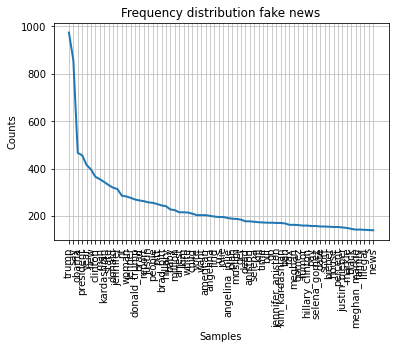

<AxesSubplot:title={'center':'Frequency distribution fake news'}, xlabel='Samples', ylabel='Counts'>

In [119]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(counts_fake)
fdist_filtered.plot(70,title='Frequency distribution fake news')

In [103]:
def text_preprocessing(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    # corpus = [remove_special_names(text) for text in corpus]

    corpus = strip_list_noempty(corpus)

    processed_texts = [text for text in nlp.pipe(corpus,  disable=["ner", "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_fake = flatten(tokenized_texts)
    counts = Counter(flat_fake)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_fake, tokenized_texts

In [104]:
real = text_preprocessing(true_text_list)

  0%|          | 0/14085 [00:00<?, ?it/s]

In [106]:
counts_real, common_real, flat_real, tokenized_texts_real = real

In [107]:
common_real[:20]

[('new', 690),
 ('say', 648),
 ('star', 619),
 ('kardashian', 566),
 ('year', 558),
 ('award', 445),
 ('reveal', 435),
 ('baby', 397),
 ('season', 384),
 ('wedding', 352),
 ('trump', 348),
 ('kim', 333),
 ('get', 324),
 ('look', 321),
 ('time', 320),
 ('watch', 319),
 ('good', 310),
 ('photo', 304),
 ('prince', 298),
 ('jenner', 293)]

In [122]:
from gensim.models import LdaMulticore

def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore( corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.01, iterations = 400)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [123]:
model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_fake, start=1, step=1, limit= 40, topn=5)


In [124]:
coherence_values

[0.1686529780150101,
 0.24132470350272492,
 0.20962482417354458,
 0.15753195786838678,
 0.2478746087794057,
 0.2030974235959299,
 0.27913611745430555,
 0.276579657627821,
 0.24411722840841976,
 0.26793785632174644,
 0.3419845720176992,
 0.2743111979649075,
 0.26305930018507234,
 0.3452015256286405,
 0.3121930045720065,
 0.3645051139261445,
 0.3867926236667265,
 0.28832304035012535,
 0.3960848044969657,
 0.37769666821891884,
 0.3018142551829081,
 0.3559199071084276,
 0.3706429014767372,
 0.36105897933252756,
 0.3466089591397596,
 0.32571885748741686,
 0.35606909395044367,
 0.38120430929625154,
 0.3586452211099456,
 0.42339243891166467,
 0.3795594953427823,
 0.3477189207461422,
 0.3564021008457257,
 0.31259420399558996,
 0.3419314251226322,
 0.3718825279216171,
 0.3684750976646342,
 0.3839738106431608,
 0.34657915614432605]

At this point the coherence scores are low, meaning there's not much confidence in the topics modelled. What if we merge the politifact dataset

In [377]:
def cleanup(text):
    res = remove_mention(text)
    res = remove_non_ascii(text)
    res = res.lower()
    res = remove_urls(res)
    res = remove_rt(res)
    res = remove_single_char(res)
    res = remove_numbers(res)
    res = remove_emojis(res)
    res = remove_nonalpha(res)
    res = remove_extra_spaces(res)
    return res

In [378]:
pf = pd.read_csv('processed-data/tweet_times/politifact_fake_tweet_times.csv')

In [379]:
cleaned_pf_text = []
for item in pf.text:
    cleaned_pf_text.append(cleanup(item))
pf.text = cleaned_pf_text

In [381]:
# cleaned_nd_text = []
# for item in new_dataset.claim_text:
#     cleaned_nd_text.append(cleanup(item))

In [219]:
# new_dataset.claim_text = cleaned_nd_text

In [220]:
# len(new_dataset.claim_text.unique())

25085

In [383]:
pf = pf.drop_duplicates(subset=['text'], keep='first')
pf = pf.sort_values('text')

In [384]:
pf.reset_index(drop=True, inplace=True)
for index, item in pf.iterrows():
    if index < len(pf)-1:
        if similar(pf.loc[index,'text'], pf.loc[index+1,'text']) > 0.90:
            pf.drop(index, inplace = True)


In [386]:
pf = pf[pf.text.notnull()]
pf = pf[pf.text != ""]
pf = pf[pf.text.str.len() > 15]

In [387]:
pf

,Unnamed: 0,created_at,text,author_id,id,news_id,withheld
2,38867,2016-06-21T14:22:52.000Z,000pound great white shark captured in great ...,3301735767,7.452607e+17,politifact14309,NaN
3,38940,2017-07-01T17:31:55.000Z,000pound great white shark captured in great ...,878694851801436161,8.812037e+17,politifact14309,NaN
4,38944,2017-07-02T00:46:24.000Z,000pound great white shark captured in great ...,72577718,8.813131e+17,politifact14309,NaN
5,38905,2017-06-22T22:49:41.000Z,000pound great white shark captured in great ...,110370047,8.780222e+17,politifact14309,NaN
6,38911,2017-06-26T20:53:35.000Z,000pound great white shark captured in great ...,90688327,8.794425e+17,politifact14309,NaN
...,...,...,...,...,...,...,...
37312,61015,2017-01-28T07:42:18.000Z,zuckerberg takes on trump on immigration calls...,790883836276060161,8.252476e+17,politifact15573,NaN
37313,16250,2018-04-11T14:13:38.000Z,zuckerberg testifying before the us house of r...,630417033,9.840720e+17,politifact14548,NaN
37314,20730,2018-07-17T11:39:18.000Z,zulumkhathini no problems,966951978172641280,1.019185e+18,politifact14548,NaN
37316,25643,2018-07-20T15:51:21.000Z,zz tops billy gibbons releases gritty muddy wa...,531242779,1.020335e+18,politifact14548,NaN


In [267]:
cleaned_pf_text = []
for item in pf.text:
    cleaned_pf_text.append(cleanup(item))
pf.text = cleaned_pf_text

,created_at,text,author_id,id,news_id
0,2017-10-03T15:48:10.000Z,"oh, gays for trump. calling on gays for trump!...",42013288,9.152421e+17,politifact15371
1,2017-10-03T16:19:10.000Z,fyi trump admin voted for death penalty for ga...,250756569,9.152499e+17,politifact15371
2,2017-10-03T21:28:30.000Z,breaking: trump votes for death penalty for be...,143618120,9.153277e+17,politifact15371
3,2017-10-03T21:28:51.000Z,"watch out, this is trump's america. us votes a...",26292109,9.153278e+17,politifact15371
4,2017-10-03T21:32:06.000Z,trump administration votes against un resoluti...,716371621380890624,9.153286e+17,politifact15371
...,...,...,...,...,...
35331,2017-03-11T19:28:08.000Z,chinese lunar rover finds no evidence of ameri...,2463640190,8.406455e+17,politifact14718
35332,2017-03-12T09:33:50.000Z,chinese lunar rover finds no evidence of ameri...,421173069,8.408584e+17,politifact14718
35333,2017-03-14T10:50:12.000Z,laugh - chinese lunar rover finds no evidence ...,228008431,8.416024e+17,politifact14718
35334,2017-03-31T07:30:11.000Z,schischowwn1 . . chinese lunar rover finds no...,2320446493,8.477126e+17,politifact14718


In [388]:
pf.to_csv('processed-data/tweets_cleaned/pf.csv')

In [164]:
combined_fake = np.append(pf_unique_text.ravel(),false.claim_text.unique().ravel())

In [139]:
false.claim_text

133        Robot security guards are patrolling a Microso...
134        Robot security guards are patrolling a Microso...
151        Amazon will open its first physical store in N...
152        Comcast is telling customers Tor is illegal to...
4740       Saudi Arabia's national airline will introduce...
                                 ...                        
2065466            Did a Cursed Mummy Sink with the Titanic?
2065467            Did a Cursed Mummy Sink with the Titanic?
2065468    Did the Chevrolet Nova Fail to Sell in Spanish...
2065469    Does a Ghost Boy Appear in ‘Three Men and a Ba...
2065470    Does a Ghost Boy Appear in ‘Three Men and a Ba...
Name: claim_text, Length: 903380, dtype: object